# Introduction

US Patent Phrase to Phrase Matching Competition challenges the participants to use innovative semantic similarity techniques to identify similar claims in the set of data.

# Analysis Preparation

Let's first import some Python packages and read the data.

In [1]:
import pandas as pd
import numpy as np
import os
import operator
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")
test_df = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")
sample_submission_df = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv")

# Preliminary Data Exploration

## Glimpse the data

In [3]:
train_df.head(2)

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75


In [4]:
test_df.head(2)

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23


In [5]:
sample_submission_df.head(2)

,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0


## Data shape

In [6]:
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission data shape: {sample_submission_df.shape}")

Train data shape: (36473, 5)
Test data shape: (36, 4)
Sample submission data shape: (36, 2)


## Missing data

In [7]:
print(f"Missing data (train/anchor): {train_df.loc[train_df.anchor.isna()].shape[0]}")
print(f"Missing data (train/target): {train_df.loc[train_df.target.isna()].shape[0]}")
print(f"Missing data (train/context): {train_df.loc[train_df.context.isna()].shape[0]}")
print(f"Missing data (test/anchor): {test_df.loc[test_df.anchor.isna()].shape[0]}")
print(f"Missing data (test/target): {test_df.loc[test_df.target.isna()].shape[0]}")
print(f"Missing data (test/context): {test_df.loc[test_df.context.isna()].shape[0]}")

Missing data (train/anchor): 0
Missing data (train/target): 0
Missing data (train/context): 0
Missing data (test/anchor): 0
Missing data (test/target): 0
Missing data (test/context): 0


## Unique data

In [8]:
print(f"Unique data (train/anchor): {train_df.anchor.nunique()} ({round(train_df.anchor.nunique()/train_df.shape[0]*100, 1)}%)")
print(f"Unique data (train/target): {train_df.target.nunique()} ({round(train_df.target.nunique()/train_df.shape[0]*100, 3)}%)")
print(f"Unique data (train/context): {train_df.context.nunique()} ({round(train_df.context.nunique()/train_df.shape[0]*100, 3)}%)")
print(f"Unique data (test/anchor): {test_df.anchor.nunique()} ({round(test_df.anchor.nunique()/test_df.shape[0]*100, 3)}%)")
print(f"Unique data (test/target): {test_df.target.nunique()} ({round(test_df.target.nunique()/test_df.shape[0]*100, 3)}%)")
print(f"Unique data (test/context): {test_df.context.nunique()} ({round(test_df.context.nunique()/test_df.shape[0]*100, 3)}%)")

Unique data (train/anchor): 733 (2.0%)
Unique data (train/target): 29340 (80.443%)
Unique data (train/context): 106 (0.291%)
Unique data (test/anchor): 34 (94.444%)
Unique data (test/target): 36 (100.0%)
Unique data (test/context): 29 (80.556%)


# Advanced Data Exploration


We will try to answer few questions about the data distribution, frequent words, frequent n-grams, possbile duplicates, words and phrases length.

## Which anchor phrases have most of target candidates?

In [9]:
g_train_df = train_df.groupby(["anchor"])["target"].count().reset_index().sort_values(["target"], ascending=False)
g_train_df.head(10)

,anchor,target
129,component composite coating,152
613,sheet supply roller,150
631,source voltage,140
482,perfluoroalkyl group,136
216,el display,135
54,average pore size,133
632,speed control means,130
476,parallel orientation,127
197,displacement mechanism,124
96,cathode layer,118


Let's also plot the distribution of number of target candidates per anchors.

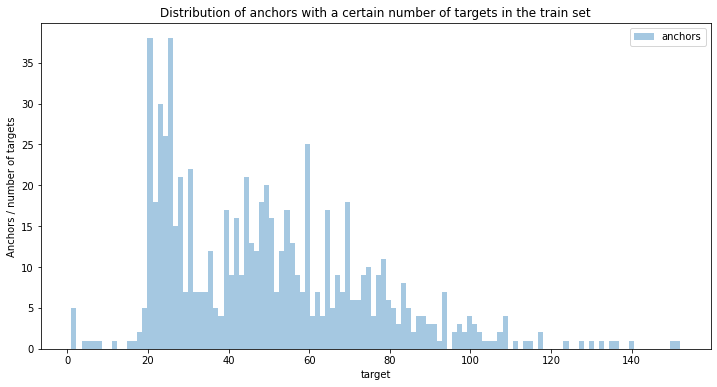

In [10]:
plt.figure(figsize=(12,6))
plt.title("Distribution of anchors with a certain number of targets in the train set")
sns.distplot(g_train_df['target'],kde=False,hist=True, bins=120, label='anchors')
plt.ylabel("Anchors / number of targets")
plt.legend(); plt.show()

## How many anchor phrases have only one target candidate?

In [11]:
g_train_df.loc[g_train_df.target==1].head(5)

,anchor,target
485,peripheral nervous system stimulation,1
136,conduct conducting material,1


It appears that there are only two anchor phrases that have only one target candidate.

## Is there any target that appears as well as an anchor?

In [12]:
anchor_target_df = train_df.loc[train_df.target.isin(list(train_df.anchor.unique()))]
anchors = anchor_target_df.anchor.unique()
targets = anchor_target_df.target.unique()
anchors_targets = set(anchors) & set(targets)
anchors_not_targets = set(anchors) - set(targets)
targets_not_anchors = set(targets) - set(anchors)
print("Anchors: ", len(anchors), " Targets: ", len(targets), " Anchors & Targets: ", len(anchors_targets))
print("Anchors that are not targets: ",  anchors_not_targets)
print("Targets that are not anchors: ", targets_not_anchors)

Anchors:  256  Targets:  258  Anchors & Targets:  247
Anchors that are not targets:  {'ack', 'weldability', 'provide acknowledgement', 'voltage patterns', 'define panel', 'inorganic hybrid', 'fluorinated olefin', 'display different pictures', 'apply to anode electrode'}
Targets that are not anchors:  {'flux regulator', 'dissolving', 'pictorial image', 'plug nozzle', 'provider networks', 'committee', 'ingress buffer', 'provide for tuning', 'provide restoring force', 'renewable power', 'cathode layer'}


Let's take a look to these anchors that appear as well as targets.

In [13]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=400,
        max_font_size=40, 
        scale=12,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(16,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

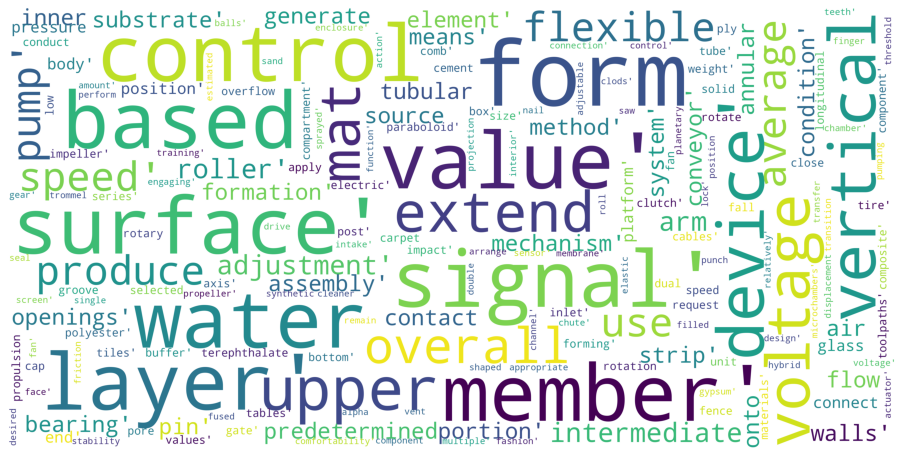

In [14]:
show_wordcloud(anchors_targets, title = '')

Let's also see in how many rows appears these targets.

In [15]:
print(f"Train data with target that appears in anchors: {train_df.loc[train_df.target.isin(anchors_targets)].shape[0]}")

Train data with target that appears in anchors: 287


But are these all cases with identity score 1.0?

In [16]:
df = train_df.loc[train_df.target.isin(anchors_targets) & train_df.score==1]
print(df.shape[0])

285


Let's see what are those cases when the score is not 1.

In [17]:
print("Data with score = 1.0 and for which target is one of the anchors: ", df.loc[df.score==1].shape[0])
print("All data with score == 1.0: ", train_df.loc[train_df.score==1].shape[0])

Data with score = 1.0 and for which target is one of the anchors:  279
All data with score == 1.0:  1154


## What is the distribution of word count and character count?

In [18]:
train_df["anchor_char_count"] = train_df["anchor"].apply(lambda x: len(x))
train_df["target_char_count"] = train_df["target"].apply(lambda x: len(x))
train_df["anchor_word_count"] = train_df["anchor"].apply(lambda x: len(x.split(" ")))
train_df["target_word_count"] = train_df["target"].apply(lambda x: len(x.split(" ")))

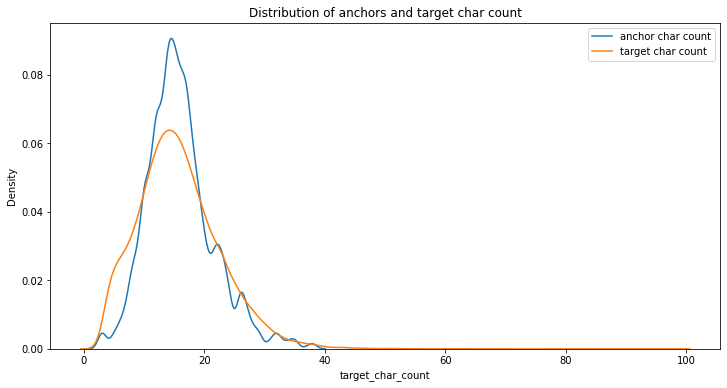

In [19]:
plt.figure(figsize=(12,6))
plt.title("Distribution of anchors and target char count")
sns.distplot(train_df['anchor_char_count'],kde=True,hist=False, bins=120, label='anchor char count')
sns.distplot(train_df['target_char_count'],kde=True,hist=False, bins=120, label='target char count')
plt.legend(); plt.show()

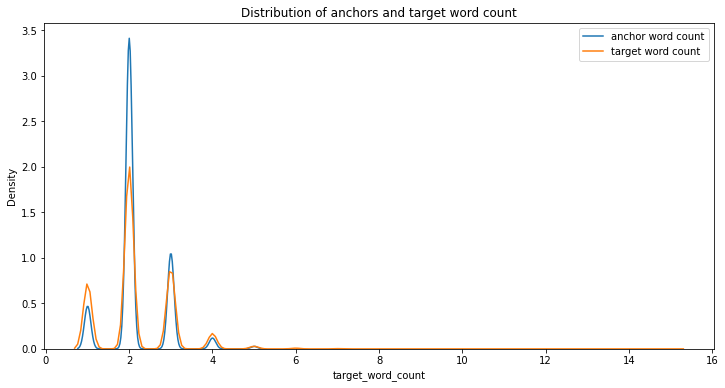

In [20]:
plt.figure(figsize=(12,6))
plt.title("Distribution of anchors and target word count")
sns.distplot(train_df['anchor_word_count'],kde=True,hist=False, bins=120, label='anchor word count')
sns.distplot(train_df['target_word_count'],kde=True,hist=False, bins=120, label='target word count')
plt.legend(); plt.show()

## How many targets have zero similarity score with anchors?

In [21]:
print("Data with zero similarity: ", train_df.loc[train_df.score==0].shape[0])

Data with zero similarity:  7471


Let's look to some examples of this data:

In [22]:
train_df.loc[train_df.score==0].sample(10).head(10)

,id,anchor,target,context,score,anchor_char_count,target_char_count,anchor_word_count,target_word_count
23803,e83149a3e8c331a2,pendent,dependent,B21,0.0,7,9,1,1
847,9425c6a39b47f1c7,adjustable multiple,improved,B25,0.0,19,8,2,1
8787,43201497aabcb994,dental aligners,hair aligners,B65,0.0,15,13,2,2
4313,d6146e70a1b8deb2,carburization,heat eyewear frames,B23,0.0,13,19,1,3
11466,c48e9e5a15050af6,end of bars,barcode scanner,D03,0.0,11,15,3,2
34875,dadeebfcbae25b9d,verifiable,differentially present,G01,0.0,10,22,1,2
23237,7e852c04ff9e517c,package member,article,B65,0.0,14,7,2,1
27389,c3b34635db33819b,regeneration agent,water,D06,0.0,18,5,2,1
30500,20c954d5f80bcd06,shunt reactor,reactor java,G01,0.0,13,12,2,2
15602,9b47e52531e32821,high gradient magnetic separators,separator manufacturer,C02,0.0,33,22,4,2


It's interesting to notice that the phrases with zero matching score have quite frequent common words. Most probably, if we will use some sort of words similarity, without semantic context, the performance of a model will not be extraordinary. We will explore this further in the next sections.

## How many contexts and how many anchor / context ?

In [23]:
print(f"Unique contexts: {train_df.context.nunique()}")

Unique contexts: 106


In [24]:
anchor_train_df = train_df[["context", "anchor"]].drop_duplicates()
print(anchor_train_df.shape[0])
grouped_df = anchor_train_df.groupby(["context"])["anchor"].count().reset_index().sort_values(["anchor"], ascending=False)
grouped_df.head(5)

1699


,context,anchor
101,H01,98
104,H04,80
88,G01,71
11,A61,66
76,F16,56


In [25]:
grouped_df.tail(5)

,context,anchor
28,B31,2
19,B08,2
2,A22,2
83,F26,1
77,F17,1


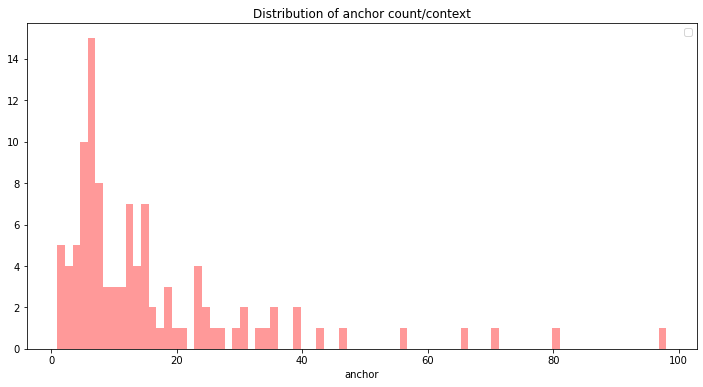

In [26]:
plt.figure(figsize=(12,6))
plt.title("Distribution of anchor count/context")
sns.distplot(grouped_df["anchor"],kde=False,hist=True, bins=80, label=None, color="red")
plt.legend(); plt.show()

## How many many targets / context?

In [27]:
grouped_df = train_df.groupby(["context"])["target"].count().reset_index().sort_values(["target"], ascending=False)
grouped_df.head(5)

,context,target
101,H01,2186
104,H04,2177
88,G01,1812
11,A61,1477
76,F16,1091


In [28]:
grouped_df.tail(5)

,context,target
16,B03,47
77,F17,33
28,B31,24
12,A62,23
83,F26,18


Let's also show the distribution of number of targets / context.

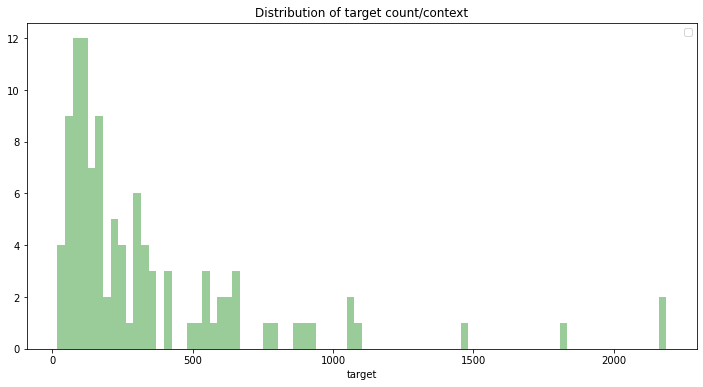

In [29]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target count/context")
sns.distplot(grouped_df["target"],kde=False,hist=True, bins=80, label=None, color='green')
plt.legend(); plt.show()

## How many context areas and how many anchor/context area?

In [30]:
train_df["context_area"] = train_df["context"].apply(lambda x: str(x)[0])
print(f"Context areas count: {train_df.context_area.nunique()}")
print(f"Context areas: {train_df.context_area.unique()}")

Context areas count: 8
Context areas: ['A' 'C' 'F' 'H' 'B' 'D' 'E' 'G']


In [31]:
anchor_train_df = train_df[["context_area", "anchor"]].drop_duplicates()
print(f"Context area + anchor: {anchor_train_df.shape[0]}")
grouped_df = anchor_train_df.groupby(["context_area"])["anchor"].count().reset_index().sort_values(["anchor"], ascending=False)
grouped_df.head(10)

Context area + anchor: 1336


,context_area,anchor
1,B,279
6,G,211
7,H,205
0,A,177
2,C,174
5,F,153
4,E,73
3,D,64


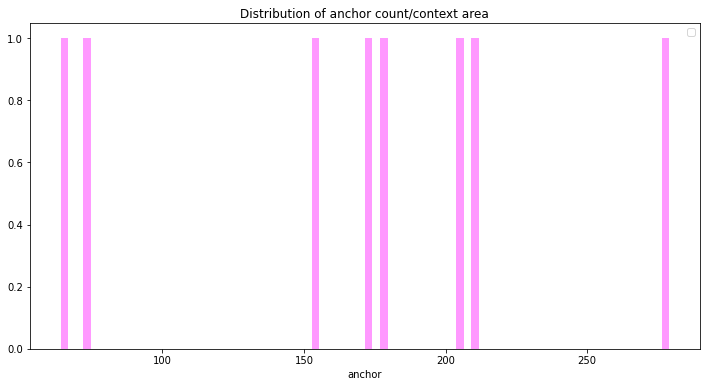

In [32]:
plt.figure(figsize=(12,6))
plt.title("Distribution of anchor count/context area")
sns.distplot(grouped_df["anchor"],kde=False,hist=True, bins=80, label=None, color='magenta')
plt.legend(); plt.show()

## How many targets/context area?

In [33]:
grouped_area_df = train_df.groupby(["context_area"])["target"].count().reset_index().sort_values(["target"], ascending=False)
grouped_area_df

,context_area,target
1,B,8019
7,H,6195
6,G,6013
2,C,5288
0,A,4094
5,F,4054
4,E,1531
3,D,1279


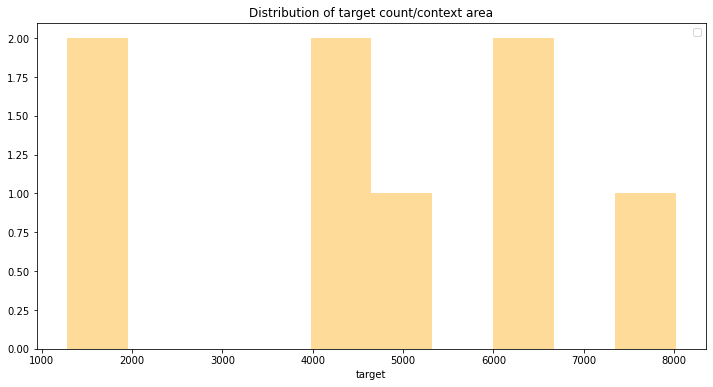

In [34]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target count/context area")
sns.distplot(grouped_area_df["target"],kde=False,hist=True, bins=10, label=None, color="orange")
plt.legend(); plt.show()

## How many context / context area?

In [35]:
grouped_area_ct_df = train_df.groupby(["context_area"])["context"].count().reset_index().sort_values(["context"], ascending=False)
grouped_area_ct_df

,context_area,context
1,B,8019
7,H,6195
6,G,6013
2,C,5288
0,A,4094
5,F,4054
4,E,1531
3,D,1279


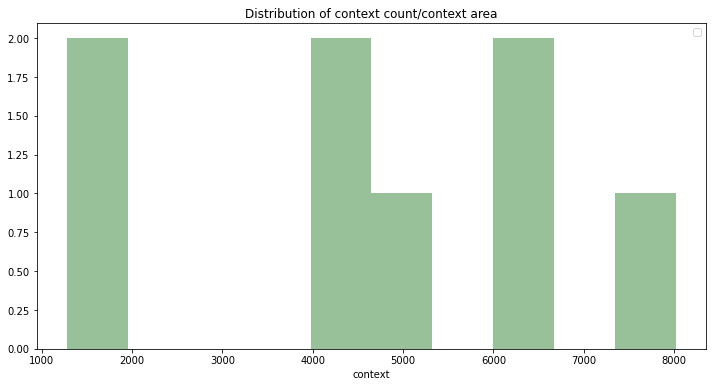

In [36]:
plt.figure(figsize=(12,6))
plt.title("Distribution of context count/context area")
sns.distplot(grouped_area_ct_df["context"],kde=False,hist=True, bins=10, label=None, color="darkgreen")
plt.legend(); plt.show()

# Is This a Model?

Let's explore some ways to calculate a score of similarity between anchor and target. We will start with very simple ones, based on levenshtein distance, word embeddings cosine simmilarity.


## Levenshtein distance 

In [37]:
from fuzzywuzzy import fuzz
def fuzzy_similarity(r):
    return fuzz.ratio(r.anchor, r.target) / 100.
train_df["fuzzy_simmilarity_score"] = train_df.apply(fuzzy_similarity, axis=1)
train_df.head(2)

,id,anchor,target,context,score,anchor_char_count,target_char_count,anchor_word_count,target_word_count,context_area,fuzzy_simmilarity_score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,9,22,1,3,A,0.58
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,9,14,1,3,A,0.43


Let's also evaluate error of the estimate using this method.

In [38]:
def compute_metrics(predictions, reference):
    return np.corrcoef(predictions, reference)[0][1]

In [39]:
fuzzy_sim_score = compute_metrics(train_df["fuzzy_simmilarity_score"].values, train_df["score"].values)
print(fuzzy_sim_score)

0.4452047827862831


Let's see the validation score if we round the score by fuzzy similarity to values of 0, 0.25, 0.5, 0.75, 1.0.

In [40]:
train_df["fuzzy_simmilarity_score_round"] = round(train_df["fuzzy_simmilarity_score"] * 4.0, 0) / 4.0

In [41]:
fuzzy_sim_score_round = compute_metrics(train_df["fuzzy_simmilarity_score_round"].values, train_df["score"].values)
print(fuzzy_sim_score_round)

0.4225375957890789


The first approximation is better.

## Word embeddings similarity

### Create vocabulary 

In [42]:
def build_vocabulary(texts):
    """
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: list of list of words
    output: dictionary of words and their count
    """
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in tqdm(sentences):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [43]:
# populate the vocabulary
df = pd.concat([train_df ,test_df], sort=False)
vocabulary_anchor = build_vocabulary(df['anchor'])
vocabulary_target = build_vocabulary(df['target'])

100%|██████████| 36509/36509 [00:00<00:00, 670619.14it/s]


In [44]:
# display the first 10 elements in anchor vocabulary and their count
print({k: vocabulary_anchor[k] for k in list(vocabulary_anchor)[:10]})

{'abatement': 49, 'abnormal': 82, 'position': 218, 'absorbent': 80, 'properties': 59, 'acan': 23, 'accept': 32, 'information': 179, 'achieve': 21, 'authentication': 21}


In [45]:
# display the first 10 elements in target vocabulary and their count
print({k: vocabulary_target[k] for k in list(vocabulary_target)[:10]})

{'abatement': 14, 'of': 763, 'pollution': 16, 'act': 6, 'abating': 2, 'active': 48, 'catalyst': 30, 'eliminating': 4, 'process': 133, 'forest': 2}


### Load embeddings

In [46]:
def load_embeddings(file):
    """
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: embeddings file
    output: embedding index
    """
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [47]:
%%time
GLOVE_PATH = '/kaggle/input/glove840b300dtxt/'
print("Extracting GloVe embedding started")
embed_glove = load_embeddings(os.path.join(GLOVE_PATH,'glove.840B.300d.txt'))
print("Embedding completed")

Extracting GloVe embedding started
Embedding completed
CPU times: user 3min 10s, sys: 12.1 s, total: 3min 22s
Wall time: 3min 28s


In [48]:
len(embed_glove)

2196017

### Embeddings coverage

Let's check embeddings coverage

In [49]:
def check_coverage(vocab, embeddings_index):
    '''
    credits to: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings 
    credits to: https://www.kaggle.com/anebzt/quora-preprocessing-model
    input: vocabulary, embedding index
    output: list of unknown words; also prints the vocabulary coverage of embeddings and the % of comments text covered by the embeddings
    '''
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in tqdm(vocab.keys()):
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass
    print('Found embeddings for {:.3%} of vocabulary'.format(len(known_words)/len(vocab)))
    print('Found embeddings for {:.3%} of all text'.format(nb_known_words/(nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    return unknown_words

In [50]:
print("Verify the intial anchor vocabulary coverage")
oov_glove_anchor = check_coverage(vocabulary_anchor, embed_glove)
print("Verify the intial target vocabulary coverage")
oov_glove_target = check_coverage(vocabulary_target, embed_glove)

Verify the intial anchor vocabulary coverage


100%|██████████| 1113/1113 [00:00<00:00, 142151.66it/s]


Found embeddings for 98.113% of vocabulary
Found embeddings for 99.049% of all text
Verify the intial target vocabulary coverage


100%|██████████| 8906/8906 [00:00<00:00, 324133.76it/s]

Found embeddings for 96.508% of vocabulary
Found embeddings for 99.485% of all text


In [51]:
print("Anchor (most frequent) words not in embeddings:\n", oov_glove_anchor[:10])
print("Target (most frequent) words not in embeddings:\n", oov_glove_target[:10])

Anchor (most frequent) words not in embeddings:
 [('microchambers', 72), ('mayenite', 57), ('halocarbyl', 55), ('bandedge', 48), ('tetracene', 47), ('biocytin', 44), ('photodefinable', 43), ('pillaring', 42), ('hexahydro', 42), ('glycitin', 39)]
Target (most frequent) words not in embeddings:
 [('photodefinable', 11), ('unclonable', 6), ('butanedioic', 6), ('pillaring', 5), ('ethanedioic', 5), ('protograph', 4), ('hexahydro', 4), ('methoxyisoflavone', 4), ('dioic', 4), ('bzatp', 3)]


In [52]:
print("Anchor total words not in embeddings: ", len(oov_glove_anchor))
print("Target total words not in embeddings: ", len(oov_glove_target))

Anchor total words not in embeddings:  21
Target total words not in embeddings:  311


### Calculate similarity

Let's apply now the cosine distance to out anchor and target phrases.

In [53]:
EMBED_SIZE = 300

def embeddings(words, embeddings_index=embed_glove):
    embedding_matrix = np.zeros((len(words) + 1, EMBED_SIZE))
    for i, word in enumerate(words):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [54]:
import gensim
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(token)     
    return result

In [55]:
import scipy
def cosine_distance_wordembedding_method(r):
    try:
        words_1 = [word for word in preprocess(r.anchor)]
        words_2 = [word for word in preprocess(r.target)]
        vector_1 = np.mean(embeddings(words_1), axis = 0)
        vector_2 = np.mean(embeddings(words_2), axis = 0) 
        cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
        return round((1-cosine),3)
    except Exception as ex:
        # if exception (missing word in embeddings), default on fuzzy wuzzy ratio (similarity score)
        print(ex)
        return fuzz.ratio(r.anchor, r.target) / 100.

In [56]:
train_df["word_embeddings_simmilarity_score"] = train_df.apply(cosine_distance_wordembedding_method, axis=1)

In [57]:
train_df[["anchor", "target", "score", "fuzzy_simmilarity_score", "word_embeddings_simmilarity_score"]].head()

,anchor,target,score,fuzzy_simmilarity_score,word_embeddings_simmilarity_score
0,abatement,abatement of pollution,0.50,0.58,0.859
1,abatement,act of abating,0.75,0.43,0.468
2,abatement,active catalyst,0.25,0.33,0.225
3,abatement,eliminating process,0.50,0.29,0.324
4,abatement,forest region,0.00,0.27,0.160


Let's compute the metrics for this score.

In [58]:
word_embeddings_simmilarity_score = compute_metrics(train_df["word_embeddings_simmilarity_score"].values, train_df["score"].values)
print(word_embeddings_simmilarity_score)

0.43487176027965696


And also let's compute the metrics for this score (with the round).

In [59]:
train_df["word_embeddings_simmilarity_score_round"] = round(train_df["word_embeddings_simmilarity_score"] * 4.0, 0) / 4.0
word_embeddings_simmilarity_score_round = compute_metrics(train_df["word_embeddings_simmilarity_score_round"].values, train_df["score"].values)
print(word_embeddings_simmilarity_score_round)

0.4104680187848462


We will use as a baseline submission the result for `word_embeddings_simmilarity_score`.

# Baseline Submission

Let's prepare a submission where we set the score based on word embeddings cosine similarity.

In [60]:
test_df["score"] = test_df.apply(cosine_distance_wordembedding_method, axis=1)

In [61]:
test_df.head()

,id,anchor,target,context,score
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,0.564
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,0.912
2,36baf228038e314b,lower trunnion,lower locating,B60,0.579
3,1f37ead645e7f0c8,cap component,upper portion,D06,0.593
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,0.730


In [62]:
sample_submission_df.head(2)

,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0


In [63]:
test_df[["id", "score"]].to_csv("submission.csv", index=False)